# DiscreteDP Example: Modeling Career Choice

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

We use `DiscreteDP` to solve the carrer-job model considered in
[http://quant-econ.net/py/career.html](http://quant-econ.net/py/career.html).

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
import quantecon as qe
from quantecon.markov import DiscreteDP

## Setup

Construct the state space:

In [3]:
# Number of possible realizations for both theta and epsilon
N = 50

# Upper bound for both theta and epsilon
B = 5

theta = np.linspace(0, B, N)   # set of theta values
epsilon = np.linspace(0, B, N) # set of epsilon values

# Set of indices for theta-epsilon pairs
s_indices2d = qe.cartesian([np.arange(N), np.arange(N)])

States are ordered as follows:

In [4]:
print(s_indices2d)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 ..., 
 [49 47]
 [49 48]
 [49 49]]


In [5]:
# Number of states
n = N * N

Distrubtions of `theta` and `epsilon`:

In [6]:
F_a, F_b = 1, 1
F_probs = qe.distributions.BetaBinomial(N-1, F_a, F_b).pdf()
F_mean = np.sum(theta * F_probs)

G_a, G_b = 1, 1
G_probs = qe.distributions.BetaBinomial(N-1, G_a, G_b).pdf()
G_mean = np.sum(epsilon * G_probs)

Construct the reward array `R` and the transition probability array `Q`:

In [7]:
# Number of actions; 0: stay put, 1: new job, 2: new life
m = 3

# Reward and transition probability arrays
R = np.empty((n, m))
Q = np.zeros((n, m, n))

# Stay put
R[:, 0] = theta[s_indices2d[:, 0]] + epsilon[s_indices2d[:, 1]]
Q[np.arange(n), 0, np.arange(n)] = 1

# New job
R[:, 1] = theta[s_indices2d[:, 0]] + G_mean
for i in range(N):
    Q[i*N:(i+1)*N, 1, i*N:(i+1)*N] = G_probs

# New life
R[:, 2] = F_mean + G_mean
Q[:, 2] = F_probs.reshape(N, 1).dot(G_probs.reshape(1, N)).ravel()

Discount factor:

In [8]:
beta = 0.95

Create a `DiscreteDP` instance:

In [9]:
ddp = DiscreteDP(R, Q, beta)

## Solving the model

Solve the Markov decision problem:

In [10]:
res = ddp.solve()

Number of iterations:

In [11]:
res.num_iter

4

The returned value function `res.v` and `res.sigma` are 1-dimenstional arrays.
To convert them to 2-dimensional arrays:

In [12]:
v_2d = res.v.reshape(N, N)
sigma_2d = res.sigma.reshape(N, N)

Plot the optimal value function:

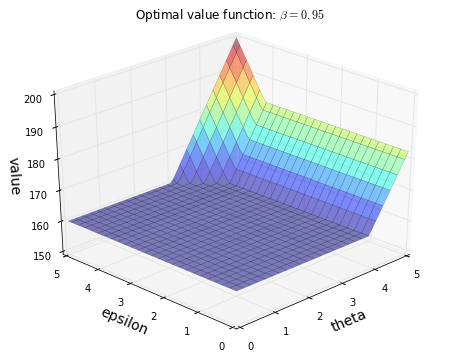

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, eg = np.meshgrid(theta, epsilon)
ax.plot_surface(tg,
                eg,
                v_2d.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_zlim(150, 200)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.set_zlabel('value', fontsize=14)
ax.view_init(ax.elev, 225)
ax.set_title(r'Optimal value function: $\beta = {0}$'
             .format(ddp.beta), y=1.05)
plt.show()

Plot the optimal policy function:

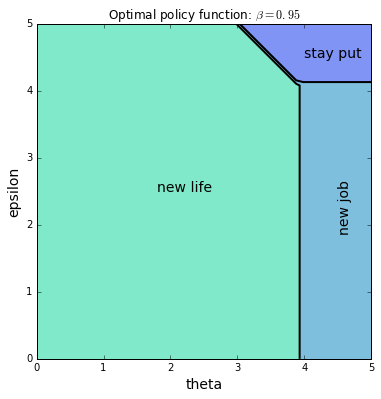

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(theta, epsilon)
lvls=(-0.5, 0.5, 1.5, 2.5)
ax.contourf(tg, eg, sigma_2d.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, sigma_2d.T, colors='k', levels=lvls, linewidths=2)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
ax.set_title(r'Optimal policy function: $\beta = {0}$'.format(ddp.beta))
plt.show()

Simulate the controlled Markov chain:

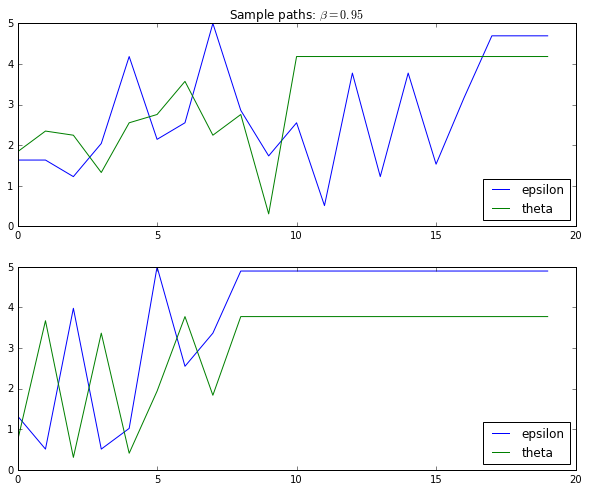

In [15]:
ts_length = 20
seed = 3210  # for replication
# seed = None  # to randomly initialize the random number generator
X = res.mc.simulate(ts_length=ts_length, num_reps=2, random_state=seed)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for x, ax in zip(X, axes):
    theta_path, epsilon_path = theta[s_indices2d[x, 0]], epsilon[s_indices2d[x, 1]]
    ax.plot(epsilon_path, label='epsilon')
    ax.plot(theta_path, label='theta')
    ax.legend(loc='lower right')
    ax.set_ylim(0, B)
axes[0].set_title(r'Sample paths: $\beta = {0}$'.format(ddp.beta))
plt.show()

Generate sample paths and compute the first passage times for the stay-put region:

In [16]:
M = 25000  # Number of samples
ts_length = 100
seed = 42
X = res.mc.simulate(ts_length=ts_length, init=0, num_reps=M, random_state=seed)

In [17]:
T_stars = (res.sigma[X] != 0).sum(axis=1)

Check that the state enters the regions before `ts_length`:

In [18]:
all(T_stars < ts_length)

True

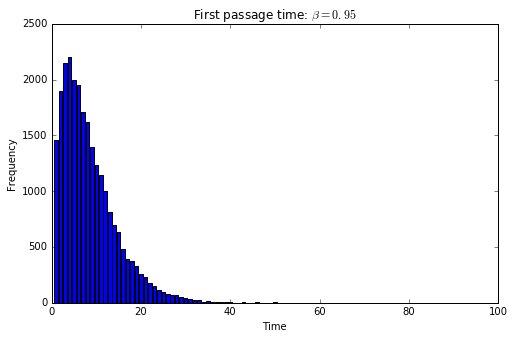

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
hist = np.histogram(T_stars, bins=T_stars.max(), range=(0, T_stars.max()))
ax.bar(np.arange(T_stars.max()), hist[0], align='center')
ax.set_xlim(0, ts_length)
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title(r'First passage time: $\beta = {0}$'.format(ddp.beta))
plt.show()

In [20]:
np.mean(T_stars)

8.4454799999999999

In [21]:
np.median(T_stars)

7.0

## Increased discount factor

Repeat the above exercises with $\beta = 0.99$.

In [22]:
ddp.beta = 0.99

In [23]:
res99 = ddp.solve()

In [24]:
v99_2d = res99.v.reshape(N, N)
sigma99_2d = res99.sigma.reshape(N, N)

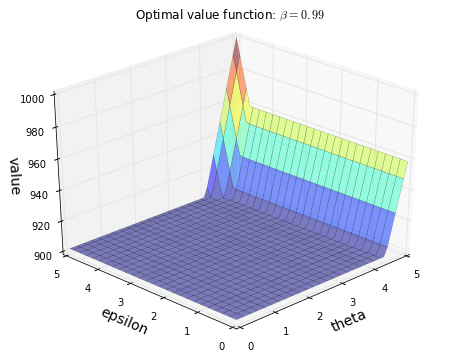

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, eg = np.meshgrid(theta, epsilon)
ax.plot_surface(tg,
                eg,
                v99_2d.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.set_zlabel('value', fontsize=14)
ax.view_init(ax.elev, 225)
ax.set_title(r'Optimal value function: $\beta = {0}$'
             .format(ddp.beta), y=1.05)
plt.show()

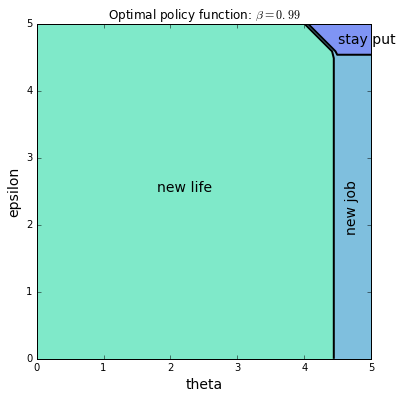

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(theta, epsilon)
lvls=(-0.5, 0.5, 1.5, 2.5)
ax.contourf(tg, eg, sigma99_2d.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, sigma99_2d.T, colors='k', levels=lvls, linewidths=2)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.6, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.5, 4.7, 'stay put', fontsize=14)
ax.set_title(r'Optimal policy function: $\beta = {0}$'.format(ddp.beta))
plt.show()

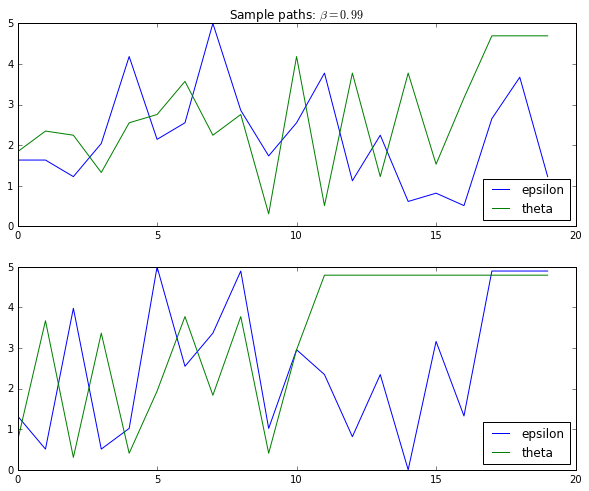

In [27]:
ts_length = 20
seed = 3210  # for replication
# seed = None  # to randomly initialize the random number generator
X = res99.mc.simulate(ts_length=ts_length, num_reps=2, random_state=seed)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for x, ax in zip(X, axes):
    theta_path, epsilon_path = theta[s_indices2d[x, 0]], epsilon[s_indices2d[x, 1]]
    ax.plot(epsilon_path, label='epsilon')
    ax.plot(theta_path, label='theta')
    ax.legend(loc='lower right')
    ax.set_ylim(0, B)
axes[0].set_title(r'Sample paths: $\beta = {0}$'.format(ddp.beta))
plt.show()

In [28]:
M = 25000 # Number of samples
ts_length = 120
seed = 42  # for replication
# seed = None  # to randomly initialize the random number generator
x = res99.mc.simulate(ts_length=ts_length, init=0, num_reps=M, random_state=seed)
T_stars = (res99.sigma[x] != 0).sum(axis=1)

In [29]:
all(T_stars < ts_length)

True

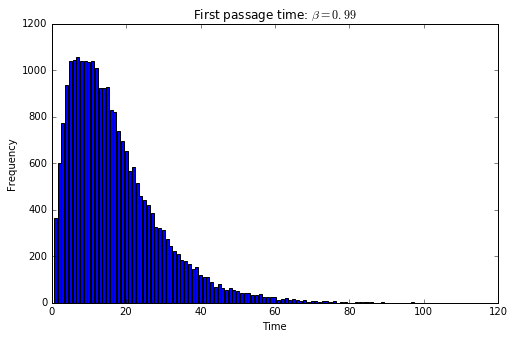

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
hist = np.histogram(T_stars, bins=T_stars.max(), range=(0, T_stars.max()))
ax.bar(np.arange(T_stars.max()), hist[0], align='center')
ax.set_xlim(0, ts_length)
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title(r'First passage time: $\beta = {0}$'.format(ddp.beta))
plt.show()

In [31]:
np.mean(T_stars)

16.93272

In [32]:
np.median(T_stars)

14.0

## Wrapping the procedure in a class

In [33]:
class CareerWorkerProblemDiscreteDP(object):
    """
    Class to solve the career-job choice model.
    
    Parameters
    ----------
    See `CareerWorkerProblem`.
    
    """
    def __init__(self, B=5.0, beta=0.95, N=50, F_a=1, F_b=1, G_a=1, G_b=1):
        self.beta, self.N, self.B = beta, N, B
        self.theta = np.linspace(0, B, N)     # set of theta values
        self.epsilon = np.linspace(0, B, N)   # set of epsilon values
        self.F_probs = qe.distributions.BetaBinomial(N-1, F_a, F_b).pdf()
        self.G_probs = qe.distributions.BetaBinomial(N-1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.theta * self.F_probs)
        self.G_mean = np.sum(self.epsilon * self.G_probs)

        self.s_indices2d = qe.cartesian((np.arange(N), np.arange(N)))
        self.s_values2d = qe.cartesian((self.theta, self.epsilon))
        n = N * N  # Number of states
        m = 3  # Number of actions; 0: stay put, 1: new job, 2: new life

        # Reward and transition probability arrays
        R = np.empty((n, m))
        Q = np.zeros((n, m, n))

        # Stay put
        R[:, 0] = self.s_values2d.sum(axis=-1)
        Q[np.arange(n), 0, np.arange(n)] = 1

        # New job
        R[:, 1] = self.s_values2d[:, 0] + self.G_mean
        for i in range(N):
            Q[i*N:(i+1)*N, 1, i*N:(i+1)*N] = self.G_probs

        # New life
        R[:, 2] = self.F_mean + self.G_mean
        Q[:, 2] = self.F_probs.reshape(N, 1).dot(self.G_probs.reshape(1, N)).ravel()
        
        self.ddp = DiscreteDP(R, Q, self.beta)
        self._mc = None
        self.num_iter = None
        
    @property
    def mc(self):
        if self._mc is None:
            self.solve()
        return self._mc
    
    def solve(self, *args, **kwargs):
        """
        Solve the model.
        
        """
        res = self.ddp.solve(*args, **kwargs)
        v = res.v.reshape(self.N, self.N)
        sigma = res.sigma.reshape(self.N, self.N)
        self._mc = res.mc
        self.num_iter = res.num_iter
        
        return v, sigma
    
    def simulate(self, ts_length, init=None, num_reps=None, random_state=None,
                 ret='state_value'):
        """
        Simulate the controlled Markov chain.
        
        """
        if init is not None:
            init = init[0]*self.N + init[1]
        X = self.mc.simulate(ts_length, init, num_reps, random_state)
        if ret == 'state_index':
            paths_index = self.s_indices2d[X]
            return paths_index
        elif ret == 'state_value':
            paths_value = self.s_values2d[X]
            return paths_value
        else:
            raise ValueError()

## Different set of parameter values

Let `G_a = G_b = 100`:

In [34]:
G_a, G_b = 100, 100
wp = CareerWorkerProblemDiscreteDP(G_a=G_a, G_b=G_b)

In [35]:
v, sigma = wp.solve()

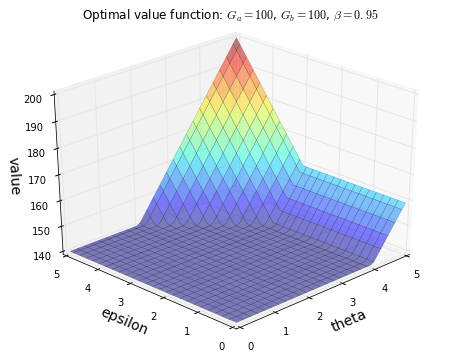

In [36]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, eg = np.meshgrid(wp.theta, wp.epsilon)
ax.plot_surface(tg,
                eg,
                v.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.set_zlabel('value', fontsize=14)
ax.view_init(ax.elev, 225)
ax.set_title(r'Optimal value function: '
             r'$G_a = {G_a}$, $G_b = {G_b}$, $\beta = {beta}$'
             .format(G_a=G_a, G_b=G_b, beta=wp.beta), y=1.05)
plt.show()

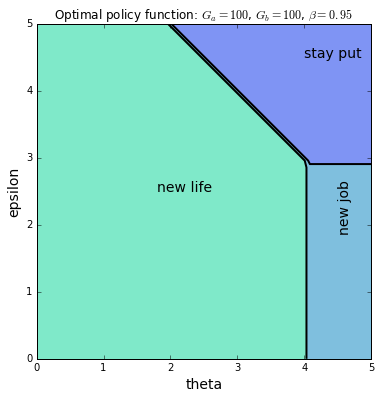

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(wp.theta, wp.epsilon)
lvls=(-0.5, 0.5, 1.5, 2.5)
ax.contourf(tg, eg, sigma.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, sigma.T, colors='k', levels=lvls, linewidths=2)
ax.set_xlabel('theta', fontsize=14)
ax.set_ylabel('epsilon', fontsize=14)
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
ax.set_title(r'Optimal policy function: '
             r'$G_a = {G_a}$, $G_b = {G_b}$, $\beta = {beta}$'
             .format(G_a=G_a, G_b=G_b, beta=wp.beta))
plt.show()

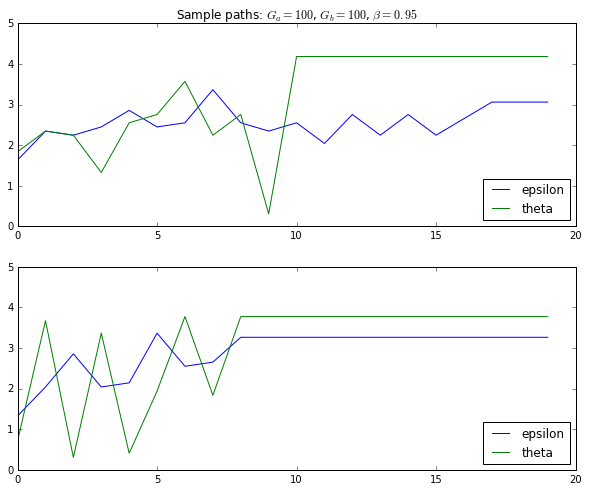

In [38]:
ts_length = 20
seed = 3210  # for replication
# seed = None  # to randomly initialize the random number generator
paths = wp.simulate(ts_length=ts_length, num_reps=2, random_state=seed)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for path, ax in zip(paths, axes):
    theta_path, epsilon_path = path[:, 0], path[:, 1]
    ax.plot(epsilon_path, label='epsilon')
    ax.plot(theta_path, label='theta')
    ax.legend(loc='lower right')
    ax.set_ylim(0, wp.B)
axes[0].set_title(r'Sample paths: '
             r'$G_a = {G_a}$, $G_b = {G_b}$, $\beta = {beta}$'
             .format(G_a=G_a, G_b=G_b, beta=wp.beta))
plt.show()

In [39]:
M = 25000 # Number of samples
ts_length = 100
seed = 42  # for replication
# seed = None  # to randomly initialize the random number generator
X = wp.simulate(ts_length=ts_length, init=(0, 0), num_reps=M, random_state=seed,
                ret='state_index')
T_stars = (sigma[X[..., 0], X[..., 1]] != 0).sum(axis=1)

In [40]:
all(T_stars < ts_length)

True

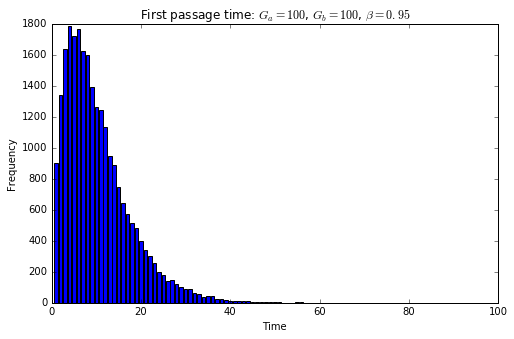

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))
hist = np.histogram(T_stars, bins=T_stars.max(), range=(0, T_stars.max()))
ax.bar(np.arange(T_stars.max()), hist[0], align='center')
ax.set_xlim(0, ts_length)
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_title(r'First passage time: '
             r'$G_a = {G_a}$, $G_b = {G_b}$, $\beta = {beta}$'
             .format(G_a=G_a, G_b=G_b, beta=wp.beta))
plt.show()

In [42]:
np.mean(T_stars)

10.31344

In [43]:
np.median(T_stars)

9.0

## Comparison with `CareerWorkerProblem`

Let us compare the above `CareerWorkerProblemDiscreteDP` with the original `CareerWorkerProblem`:

With `quantecon` version 0.3 or above,
we need to download the script file `career.py` from the `career` directory
in the [QuantEcon.applications](https://github.com/QuantEcon/QuantEcon.applications) repo.

In [44]:
# Download the module file and then import it
module = "career"
directory = "career"
object_name = "CareerWorkerProblem"
file = module + ".py"
repo = "https://github.com/QuantEcon/QuantEcon.applications"
qe.util.fetch_nb_dependencies(files=[file], repo=repo, deps=directory)

exec("from {0} import {1}".format(module, object_name))

Fetching file: career.py


We are now ready to use `CareerWorkerProblem`.

In [45]:
wp_orig = CareerWorkerProblem()
wp_ddp = CareerWorkerProblemDiscreteDP()

Solve the model by value iteration with `max_iter = 50`,
which is the default value in `qe.compute_fixed_point`:

In [46]:
v_init = np.ones((wp_orig.N, wp_orig.N))*100
v_orig = qe.compute_fixed_point(wp_orig.bellman_operator, v_init, verbose=False)
sigma_orig = wp_orig.get_greedy(v_orig)

In [47]:
v_init_1d = np.ones(wp_orig.N*wp_orig.N)*100
error_tol = 1e-3
epsilon = error_tol * (2*wp_orig.beta) / (1-wp_orig.beta)
v_ddp, sigma_ddp = \
    wp_ddp.solve(method='vi', v_init=v_init_1d, epsilon=epsilon, max_iter=50)

In [48]:
np.abs(v_orig - v_ddp).max()

7.673861546209082e-13

In [49]:
np.array_equal(sigma_orig-1, sigma_ddp)

True

`max_iter = 50` is binding:

In [50]:
wp_ddp.num_iter

50

Solve by policy iteration:

In [51]:
v_ddp_pi, sigma_ddp_pi = \
    wp_ddp.solve(method='pi', v_init=v_init_1d)

In [52]:
np.abs(v_orig - v_ddp_pi).max()

7.6944975276712739

In [53]:
np.array_equal(sigma_orig-1, sigma_ddp_pi)

False

In [54]:
(sigma_orig-1 != sigma_ddp_pi).sum()

50

In [55]:
np.where(sigma_orig-1 != sigma_ddp_pi)

(array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38]),
 array([49, 48, 47, 46, 45, 44, 43, 42, 41,  0,  1,  2,  3,  4,  5,  6,  7,
         8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]))

Increse `max_iter`:

In [56]:
v_ddp2, sigma_ddp2 = \
    wp_ddp.solve(method='vi', v_init=v_init_1d, epsilon=epsilon, max_iter=250)

In [57]:
wp_ddp.num_iter

168

In [58]:
v_init = np.ones((wp_orig.N, wp_orig.N))*100
v_orig2 = qe.compute_fixed_point(wp_orig.bellman_operator, v_init, verbose=False,
                                 max_iter=250)
sigma_orig2 = wp_orig.get_greedy(v_orig2)

In [59]:
np.array_equal(sigma_orig2-1, sigma_ddp_pi)

True

Consider the case of $\beta = 0.99$.

In [60]:
beta = 0.99
wp_orig99 = CareerWorkerProblem(beta=beta)
wp_ddp99 = CareerWorkerProblemDiscreteDP(beta=beta)

In [61]:
v_init = np.ones((wp_orig99.N, wp_orig99.N))*100
v_orig99 = qe.compute_fixed_point(wp_orig99.bellman_operator, v_init, verbose=False)
sigma_orig99 = wp_orig99.get_greedy(v_orig99)

In [62]:
v_init_1d = np.ones(wp_orig.N*wp_orig.N)*100
error_tol = 1e-3
epsilon = error_tol * (2*wp_orig.beta) / (1-wp_orig.beta)
v_ddp99, sigma_ddp99 = \
    wp_ddp99.solve(method='vi', v_init=v_init_1d, epsilon=epsilon, max_iter=50)

In [63]:
np.array_equal(sigma_orig99-1, sigma_ddp99)

True

In [64]:
v_ddp99_pi, sigma_ddp99_pi = \
    wp_ddp99.solve(method='pi', v_init=v_init_1d)

In [65]:
np.array_equal(sigma_orig99-1, sigma_ddp99_pi)

False

In [66]:
(sigma_orig99-1 != sigma_ddp99_pi).sum()

180

In [67]:
F = qe.DiscreteRV(wp_orig99.F_probs)
G = qe.DiscreteRV(wp_orig99.G_probs)

def gen_first_passage_time(sigma):
    t = 0
    i = j = 0
    while 1:
        if sigma[i, j] == 1:    # Stay put
            return t
        elif sigma[i, j] == 2:  # New job
            j = int(G.draw())
        else:                   # New life
            i, j  = int(F.draw()), int(G.draw())
        t += 1

M = 25000 # Number of samples
samples = np.empty(M)
for i in range(M): 
    samples[i] = gen_first_passage_time(sigma=sigma_orig99)
print(np.median(samples))

9.0


In [68]:
M = 25000 # Number of samples
ts_length = 120
seed = 42  # for replication
# seed = None  # to randomly initialize the random number generator
X = wp_ddp99.simulate(ts_length=ts_length, init=(0, 0), num_reps=M, random_state=seed,
                      ret='state_index')
T_stars = (sigma_ddp99[X[..., 0], X[..., 1]] != 0).sum(axis=1)
np.median(T_stars)

14.0

Increase `max_iter` for value iteration:

In [69]:
v_ddp99, sigma_ddp99 = \
    wp_ddp99.solve(method='vi', v_init=v_init_1d, epsilon=epsilon, max_iter=2000)

In [70]:
wp_ddp99.num_iter

1072

In [71]:
np.array_equal(sigma_ddp99, sigma_ddp99_pi)

True

In [72]:
v_init = np.ones((wp_orig99.N, wp_orig99.N))*100
v_orig99 = qe.compute_fixed_point(wp_orig99.bellman_operator, v_init, verbose=False,
                                  max_iter=2000)
sigma_orig99 = wp_orig99.get_greedy(v_orig99)

In [73]:
M = 25000 # Number of samples
samples = np.empty(M)
for i in range(M): 
    samples[i] = gen_first_passage_time(sigma=sigma_orig99)
print(np.median(samples))

14.0
